### Obtained Perplexity: -8.68, Coherence: 0.31, Best Number of Topics= 50

In [1]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
#Load Dataset
df=pd.read_csv('/home/smriti/Desktop/NLP/MITACS/Anxiety/Data/CSV/Medium/medium_text_2015.csv')
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#Combining title and text
df["Post"] = df["title"] + df["text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['title', 'text'], axis = 1)

/home/smriti/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [4]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
df.head()

,year,Post
0,2015,What Could Go Right?The internet threw up a ch...
1,2015,Mindfulness DeconstructedAlmost every week we ...
2,2015,How To Deal With a BullyLessons From Kindergar...
3,2015,"Pink Water BottleA man, whose name we’ll never..."
4,2015,A Self-Hypnosis workshop to help Ease Anxiety ...


In [6]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [7]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [8]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['what', 'could', 'go', 'right', 'the', 'internet', 'threw', 'up', 'cheesy', 'quote', 'recently', 'stop', 'being', 'afraid', 'of', 'what', 'could', 'go', 'wrong', 'and', 'start', 'being', 'positive', 'about', 'what', 'could', 'go', 'right', 'pinned', 'it', 'because', 'do', 'that', 'sort', 'of', 'thing', 'and', 'thought', 'it', 'was', 'forever', 'filed', 'in', 'forgettable', 'fuzzy', 'trivia', 'it', 'wasn', 'the', 'notion', 'buzzes', 'around', 'in', 'my', 'bonnet', 'all', 'day', 'and', 'at', 'night', 'when', 'can', 'sleep', 'it', 'grabbed', 'my', 'attention', 'spoke', 'to', 'me', 'just', 'me', 'and', 'now', 'can', 'let', 'it', 'go', 'get', 'mad', 'at', 'myself', 'when', 'sucked', 'in', 'by', 'second', 'rate', 'feel', 'good', 'soundbites', 'which', 'is', 'fairly', 'often', 'so', 'am', 'pretty', 'consistently', 'vexed', 'if', 'in', 'minor', 'way', 'but', 'here', 'the', 'thing', 'am', 'afraid', 'very', 'afraid', 'of', 'what', 'could', 'go', 'and', 'often', 'has', 'gone', 'wrong', 'tiptoe'

In [9]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [10]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [11]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['what', 'could', 'go', 'right', 'the', 'internet', 'threw', 'up', 'cheesy', 'quote', 'recently', 'stop', 'being', 'afraid', 'of', 'what', 'could', 'go', 'wrong', 'and', 'start', 'being', 'positive', 'about', 'what', 'could', 'go', 'right', 'pinned', 'it', 'because', 'do', 'that', 'sort', 'of', 'thing', 'and', 'thought', 'it', 'was', 'forever', 'filed', 'in', 'forgettable', 'fuzzy', 'trivia', 'it', 'wasn', 'the', 'notion', 'buzzes', 'around', 'in', 'my', 'bonnet', 'all', 'day', 'and', 'at', 'night', 'when', 'can', 'sleep', 'it', 'grabbed', 'my', 'attention', 'spoke', 'to', 'me', 'just', 'me', 'and', 'now', 'can', 'let', 'it', 'go', 'get', 'mad', 'at', 'myself', 'when', 'sucked', 'in', 'by', 'second', 'rate', 'feel', 'good', 'soundbites', 'which', 'is', 'fairly', 'often', 'so', 'am', 'pretty', 'consistently', 'vexed', 'if', 'in', 'minor', 'way', 'but', 'here', 'the', 'thing', 'am', 'afraid', 'very', 'afraid', 'of', 'what', 'could', 'go', 'and', 'often', 'has', 'gone', 'wrong', 'tiptoe',

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [13]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [27]:
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

# Create Dictionary needed for topic modelling
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=50,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

[['could', 'go', 'right', 'internet', 'throw', 'cheesy', 'recently', 'stop', 'afraid', 'could', 'go', 'wrong', 'start', 'positive', 'could', 'go', 'right', 'pin', 'sort', 'thing', 'think', 'forever', 'file', 'forgettable', 'fuzzy', 'trivia', 'notion', 'buzz', 'day', 'night', 'sleep', 'grab', 'attention', 'speak', 'let', 'go', 'mad', 'sucked', 'second', 'rate', 'feel', 'good', 'soundbite', 'fairly', 'often', 'pretty', 'consistently', 'vex', 'minor', 'way', 'thing', 'afraid', 'afraid', 'could', 'go', 'often', 'go', 'wrong', 'tiptoe', 'day', 'imagine', 'could', 'go', 'wrong', 'could', 'go', 'wrong', 'record', 'always', 'explain', 'become', 'bad', 'case', 'scenario', 'example', 'wake', 'last', 'night', 'lie', 'hour', 'worry', 'mightily', 'follow', 'clearly', 'mind', 'lie', 'messy', 'lovely', 'peaceful', 'surround', 'healthy', 'family', 'feel', 'happy', 'relatively', 'nice', 'life', 'much', 'bad', 'hour', 'back', 'occur', 'often', 'imagine', 'could', 'go', 'right', 'panic', 'probably', 'go'

In [28]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(11,
  '0.000*"say" + 0.000*"trigger" + 0.000*"time" + 0.000*"life" + '
  '0.000*"people" + 0.000*"would" + 0.000*"know" + 0.000*"much" + 0.000*"get" '
  '+ 0.000*"tell"'),
 (45,
  '0.000*"go" + 0.000*"get" + 0.000*"work" + 0.000*"people" + 0.000*"know" + '
  '0.000*"time" + 0.000*"feel" + 0.000*"anxiety" + 0.000*"even" + '
  '0.000*"would"'),
 (25,
  '0.000*"feel" + 0.000*"anxiety" + 0.000*"go" + 0.000*"time" + 0.000*"make" + '
  '0.000*"would" + 0.000*"people" + 0.000*"take" + 0.000*"get" + '
  '0.000*"thing"'),
 (23,
  '0.001*"go" + 0.000*"anxiety" + 0.000*"thing" + 0.000*"time" + 0.000*"get" + '
  '0.000*"think" + 0.000*"could" + 0.000*"people" + 0.000*"feel" + '
  '0.000*"really"'),
 (6,
  '0.007*"making" + 0.007*"overcoming" + 0.007*"alleviate" + 0.007*"envision" '
  '+ 0.007*"usual" + 0.007*"lettershoppe" + 0.007*"odd" + 0.007*"outcast" + '
  '0.007*"prevent" + 0.003*"behavioral"'),
 (26,
  '0.001*"anxiety" + 0.001*"time" + 0.000*"people" + 0.000*"trigger" + '
  '0.000*"day" + 

In [29]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -8.686276916161823


In [30]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3167938844065412


In [18]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [19]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.9965,"go, feel, get, thing, think, time, would, try,...","[could, go, right, internet, throw, cheesy, re..."
1,1,1.0,0.9012,"people, think, thing, know, feel, time, anxiet...","[mindfulness, week, hear, new, way, mindfulnes..."
2,2,3.0,0.9942,"make, people, time, work, get, take, job, go, ...","[deal, bullylesson, kindergarten, update, say,..."
3,3,28.0,0.9985,"tell, go, look, first, time, get, day, know, c...","[pink, water, bottlea, man, name, never, know,..."
4,4,32.0,0.9818,"meditation, practice, anxiety, technique, help...","[help, ease, anxiety, hypnotherapist, show, po..."


In [20]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.9965,"go, feel, get, thing, think, time, would, try,...","[could, go, right, internet, throw, cheesy, re..."
1,1,1.0,0.9012,"people, think, thing, know, feel, time, anxiet...","[mindfulness, week, hear, new, way, mindfulnes..."
2,2,3.0,0.9942,"make, people, time, work, get, take, job, go, ...","[deal, bullylesson, kindergarten, update, say,..."
3,3,28.0,0.9985,"tell, go, look, first, time, get, day, know, c...","[pink, water, bottlea, man, name, never, know,..."
4,4,32.0,0.9818,"meditation, practice, anxiety, technique, help...","[help, ease, anxiety, hypnotherapist, show, po..."
5,5,32.0,0.9818,"meditation, practice, anxiety, technique, help...","[help, ease, anxiety, hypnotherapist, show, po..."
6,6,1.0,0.5803,"people, think, thing, know, feel, time, anxiet...","[self, never, bully, silence, never, allow, ma..."
7,7,27.0,0.7816,"would, anxiety, think, could, never, know, mak...","[get, verse, national, terrible, love, swell, ..."
8,8,1.0,0.9982,"people, think, thing, know, feel, time, anxiet...","[ditch, know, thing, wish, time, head, wrong, ..."
9,9,15.0,0.5793,"feel, people, know, look, social, think, make,...","[strong, class, face, social, judgement, perce..."


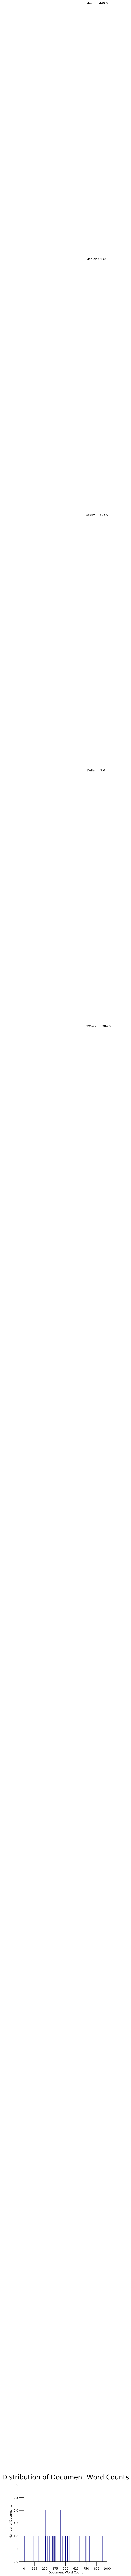

In [21]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

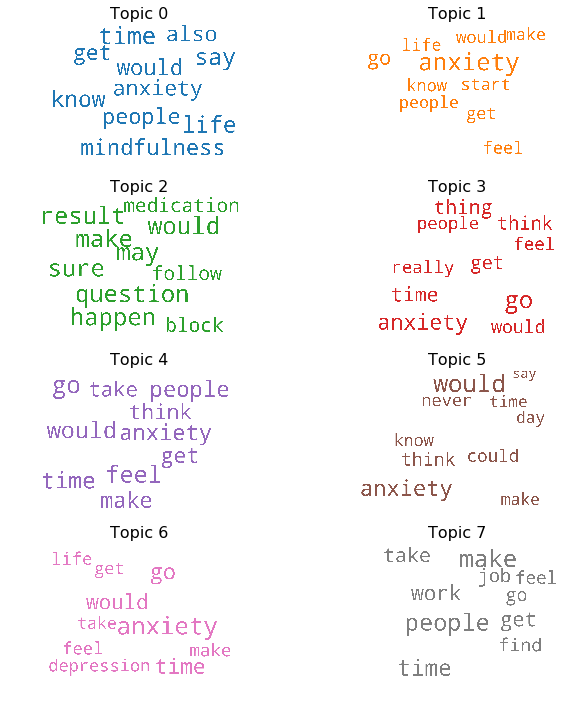

In [22]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [23]:
df_dominant_topic.to_csv("Medium2015.csv")

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=20, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=6)

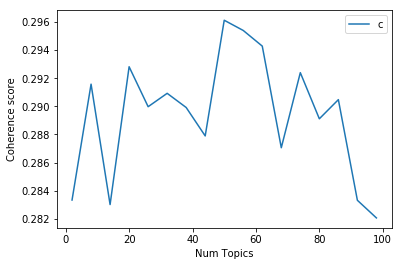

In [26]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')